In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
  #   for filename in filenames:
    #     print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## To display the graphs within the code and not in another windows 
import sys
print("Python Version :"+str(sys.version_info))
%matplotlib inline
# To be able to use CSV
import csv
print("CSV Version :"+csv.__version__)
# To be able to use Numpy
import numpy as np
print("Numpy Version :"+np.__version__)
# To be able to use Pandas
import pandas as pd
print("Pandas Version :"+pd.__version__)
# To be able to use Maplotlib
import matplotlib.pyplot as plt
import time
# To be able to use Seaborn
import seaborn as sns
print("Seaborn Version :"+sns.__version__)

import cv2 as cv
print("Open CV Version :"+cv.__version__)

from PIL import Image

# To be able to use Warning
import warnings
import os
import shutil
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from scipy.spatial import distance
from sklearn.metrics import silhouette_score
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.xception import preprocess_input
from keras.applications import *
from keras.applications.xception import decode_predictions
from keras.layers import Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import *
from keras.layers.core import Dropout

import tensorflow as tf
print("Keras Version : "+tf.keras.__version__)
print("Tensorflow Version : "+tf.__version__)

Python Version :sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
CSV Version :1.0
Numpy Version :1.18.5
Pandas Version :1.1.0
Seaborn Version :0.10.0
Open CV Version :4.3.0
Keras Version : 2.4.0
Tensorflow Version : 2.3.0


In [17]:
images_directory = '/kaggle/input/mydogs/'
train_directory = '/kaggle/input/mydogs/train/'
test_directory = '/kaggle/input/mydogs/test/'
main_categories = [directory for directory in os.listdir(train_directory)]
main_categories.sort()
batch_size = 2

In [18]:
class MixupImageDataGenerator():
    def __init__(self, generator, directory, batch_size, img_height, img_width, alpha=0.2, subset=None):
        """Constructor for mixup image data generator.
        Arguments:
            generator {object} -- An instance of Keras ImageDataGenerator.
            directory {str} -- Image directory.
            batch_size {int} -- Batch size.
            img_height {int} -- Image height in pixels.
            img_width {int} -- Image width in pixels.
        Keyword Arguments:
            alpha {float} -- Mixup beta distribution alpha parameter. (default: {0.2})
            subset {str} -- 'training' or 'validation' if validation_split is specified in
            `generator` (ImageDataGenerator).(default: {None})
        """

        self.batch_index = 0
        self.batch_size = batch_size
        self.alpha = alpha

        # First iterator yielding tuples of (x, y)
        self.generator1 = generator.flow_from_directory(directory,
                                                        target_size=(
                                                            img_height, img_width),
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset)

        # Second iterator yielding tuples of (x, y)
        self.generator2 = generator.flow_from_directory(directory,
                                                        target_size=(
                                                            img_height, img_width),
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset)

        # Number of images across all classes in image directory.
        self.n = self.generator1.samples

    def reset_index(self):
        """Reset the generator indexes array.
        """

        self.generator1._set_index_array()
        self.generator2._set_index_array()

    def on_epoch_end(self):
        self.reset_index()

    def reset(self):
        self.batch_index = 0

    def __len__(self):
        # round up
        return (self.n + self.batch_size - 1) // self.batch_size

    def get_steps_per_epoch(self):
        """Get number of steps per epoch based on batch size and
        number of images.
        Returns:
            int -- steps per epoch.
        """

        return self.n // self.batch_size

    def __next__(self):
        """Get next batch input/output pair.
        Returns:
            tuple -- batch of input/output pair, (inputs, outputs).
        """

        if self.batch_index == 0:
            self.reset_index()

        current_index = (self.batch_index * self.batch_size) % self.n
        if self.n > current_index + self.batch_size:
            self.batch_index += 1
        else:
            self.batch_index = 0

        # random sample the lambda value from beta distribution.
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)

        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        # Get a pair of inputs and outputs from two iterators.
        X1, y1 = self.generator1.next()
        X2, y2 = self.generator2.next()

        # Perform the mixup.
        X = X1 * X_l + X2 * (1 - X_l)
        y = y1 * y_l + y2 * (1 - y_l)
        return X, y

    def __iter__(self):
        while True:
            yield next(self)

In [19]:
main_categories

['Affenpinscher',
 'AfghanHound',
 'AfricanHuntingDog',
 'Airedale',
 'AmericanStaffordshireTerrier',
 'Appenzeller',
 'AustralianTerrier',
 'Basenji',
 'Basset',
 'Beagle',
 'BedlingtonTerrier',
 'BerneseMountainDog',
 'Black',
 'BlenheimSpaniel',
 'Bloodhound',
 'Bluetick',
 'BorderCollie',
 'BorderTerrier',
 'Borzoi',
 'BostonBull',
 'BouvierDesFlandres',
 'Boxer',
 'BrabanconGriffon',
 'Briard',
 'BrittanySpaniel',
 'BullMastiff',
 'Cairn',
 'Cardigan',
 'ChesapeakeBayRetriever',
 'Chihuahua',
 'Chow',
 'Clumber',
 'CockerSpaniel',
 'Collie',
 'Curly',
 'DandieDinmont',
 'Dhole',
 'Dingo',
 'Doberman',
 'EnglishFoxhound',
 'EnglishSetter',
 'EnglishSpringer',
 'Entlebucher',
 'EskimoDog',
 'Flat',
 'FrenchBulldog',
 'GermanShepherd',
 'GermanShort',
 'GiantSchnauzer',
 'GoldenRetriever',
 'GordonSetter',
 'GreatDane',
 'GreatPyrenees',
 'GreaterSwissMountainDog',
 'Groenendael',
 'IbizanHound',
 'IrishSetter',
 'IrishTerrier',
 'IrishWaterSpaniel',
 'IrishWolfhound',
 'ItalianGreyh

In [20]:
number_of_categories = len(main_categories)

# Split among the Train / Test / Validation images¶

In [21]:
# train_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)
transformation_ratio = .05
train_datagen = ImageDataGenerator(rescale=1. / 255, rotation_range=transformation_ratio, shear_range=transformation_ratio, zoom_range=transformation_ratio, cval=transformation_ratio, horizontal_flip=True, vertical_flip=True, validation_split=0.2)

# train_datagen = ImageDataGenerator(
  #  rescale=1/255,
  #  rotation_range=40,
  #  width_shift_range=0.2,
  #  height_shift_range=0.2,
  #  shear_range=0.2,
  #  zoom_range=0.2,
  #  horizontal_flip=True,
  #  validation_split=0.2
#)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [22]:
train_generator = MixupImageDataGenerator(generator=train_datagen,
                                          directory=train_directory,
                                          batch_size=batch_size,
                                          img_height=224,
                                          img_width=224,
                                          subset='training')

validation_generator = train_datagen.flow_from_directory(train_directory, target_size=(224, 224), batch_size=batch_size, class_mode='categorical', classes=main_categories, subset='validation', shuffle=True)

Found 11664 images belonging to 120 classes.
Found 11664 images belonging to 120 classes.
Found 2853 images belonging to 120 classes.


In [23]:
test_generator = test_datagen.flow_from_directory(test_directory, target_size=(224, 224), batch_size=batch_size, class_mode='categorical', classes=main_categories, shuffle=False)

Found 6063 images belonging to 120 classes.


# Definition of the model

In [24]:
 model = Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [25]:

model.trainable = False

# choose the layers which are updated by training
layer_num = len(model.layers)
for layer in model.layers[:int(layer_num * 0.9)]:
    layer.trainable = False

for layer in model.layers[int(layer_num * 0.9):]:
    layer.trainable = True
x = model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.5)(x)
# Ajouter la nouvelle couche fully-connected pour la classification 7 classes
predictions = Dense(number_of_categories, activation='softmax')(x)

# Définir le nouveau modèle
new_model = Model(inputs=model.input, outputs=predictions)

In [26]:
print(new_model.summary())

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [27]:
train_generator.reset()
validation_generator.reset()
# Compiler le modèle
# new_model.compile(loss="categorical_crossentropy", optimizer='nadam', metrics=["accuracy"])
# new_model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
# new_model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.01, momentum=0.9), metrics=["accuracy"])
new_model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])

In [28]:
earlystopping = EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True) 

In [29]:
start_time = time.time()

In [30]:
model_info = new_model.fit_generator(train_generator, validation_data=validation_generator, epochs=30, verbose=2, callbacks=[earlystopping], steps_per_epoch=train_generator.get_steps_per_epoch(), validation_steps=validation_generator.samples // batch_size)

Epoch 1/30
5832/5832 - 415s - loss: 3.8710 - accuracy: 0.1852 - val_loss: 2.1088 - val_accuracy: 0.4667
Epoch 2/30
5832/5832 - 411s - loss: 2.8128 - accuracy: 0.3920 - val_loss: 1.9639 - val_accuracy: 0.5477
Epoch 3/30
5832/5832 - 415s - loss: 2.4334 - accuracy: 0.4714 - val_loss: 1.9175 - val_accuracy: 0.5698
Epoch 4/30
5832/5832 - 405s - loss: 2.2475 - accuracy: 0.5159 - val_loss: 2.1154 - val_accuracy: 0.5806
Epoch 5/30
5832/5832 - 398s - loss: 2.1289 - accuracy: 0.5538 - val_loss: 2.0652 - val_accuracy: 0.5989
Epoch 6/30
5832/5832 - 396s - loss: 2.0244 - accuracy: 0.5844 - val_loss: 1.8722 - val_accuracy: 0.6248
Epoch 7/30
5832/5832 - 391s - loss: 1.9638 - accuracy: 0.6002 - val_loss: 2.0888 - val_accuracy: 0.6171
Epoch 8/30
5832/5832 - 388s - loss: 1.8758 - accuracy: 0.6222 - val_loss: 1.9178 - val_accuracy: 0.6388
Epoch 9/30
5832/5832 - 389s - loss: 1.8184 - accuracy: 0.6438 - val_loss: 2.1316 - val_accuracy: 0.6343
Epoch 10/30
5832/5832 - 395s - loss: 1.7774 - accuracy: 0.6488 -

In [31]:
print("Time:"+ (str)(time.time()-start_time))

Time:4406.90290927887


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


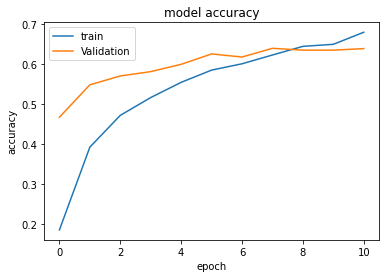

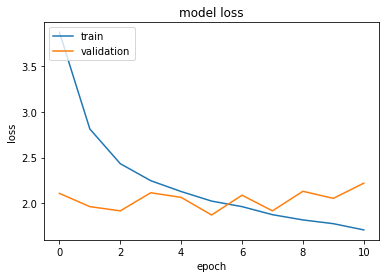

In [32]:
# list all data in history
print(model_info.history.keys())
# summarize history for accuracy
plt.plot(model_info.history['accuracy'])
plt.plot(model_info.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_info.history['loss'])
plt.plot(model_info.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [33]:
test_generator.reset()
score = new_model.evaluate_generator(test_generator, (test_generator.samples + (batch_size-1)) // batch_size)
print("For test data set; Loss: ",score[0]," Accuracy: ", score[1])

For test data set; Loss:  1.1488215923309326  Accuracy:  0.7464951276779175


In [34]:
test_generator.reset()

testStep = (test_generator.samples + (batch_size-1)) // batch_size
print("testStep: ", testStep)

testStep:  3032


In [35]:
Y_pred = new_model.predict_generator(test_generator, steps=testStep, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)
print(str(len(y_pred)))
labels = (validation_generator.class_indices)
print("Labels "+(str)(labels))
labels = dict((v, k) for k, v in labels.items())
print(labels)
predictedLabels = [labels[k] for k in y_pred]
#print("Predicted Labels "+(str)(predictedLabels))
len(predictedLabels)
actualLabels = [labels[k] for k in test_generator.classes]
print("Actual Labels "+(str)(actualLabels))
len(actualLabels)

3032/3032 - 37s
[  0   0   0 ... 119  70 119]
6063
Labels {'Affenpinscher': 0, 'AfghanHound': 1, 'AfricanHuntingDog': 2, 'Airedale': 3, 'AmericanStaffordshireTerrier': 4, 'Appenzeller': 5, 'AustralianTerrier': 6, 'Basenji': 7, 'Basset': 8, 'Beagle': 9, 'BedlingtonTerrier': 10, 'BerneseMountainDog': 11, 'Black': 12, 'BlenheimSpaniel': 13, 'Bloodhound': 14, 'Bluetick': 15, 'BorderCollie': 16, 'BorderTerrier': 17, 'Borzoi': 18, 'BostonBull': 19, 'BouvierDesFlandres': 20, 'Boxer': 21, 'BrabanconGriffon': 22, 'Briard': 23, 'BrittanySpaniel': 24, 'BullMastiff': 25, 'Cairn': 26, 'Cardigan': 27, 'ChesapeakeBayRetriever': 28, 'Chihuahua': 29, 'Chow': 30, 'Clumber': 31, 'CockerSpaniel': 32, 'Collie': 33, 'Curly': 34, 'DandieDinmont': 35, 'Dhole': 36, 'Dingo': 37, 'Doberman': 38, 'EnglishFoxhound': 39, 'EnglishSetter': 40, 'EnglishSpringer': 41, 'Entlebucher': 42, 'EskimoDog': 43, 'Flat': 44, 'FrenchBulldog': 45, 'GermanShepherd': 46, 'GermanShort': 47, 'GiantSchnauzer': 48, 'GoldenRetriever': 49

6063

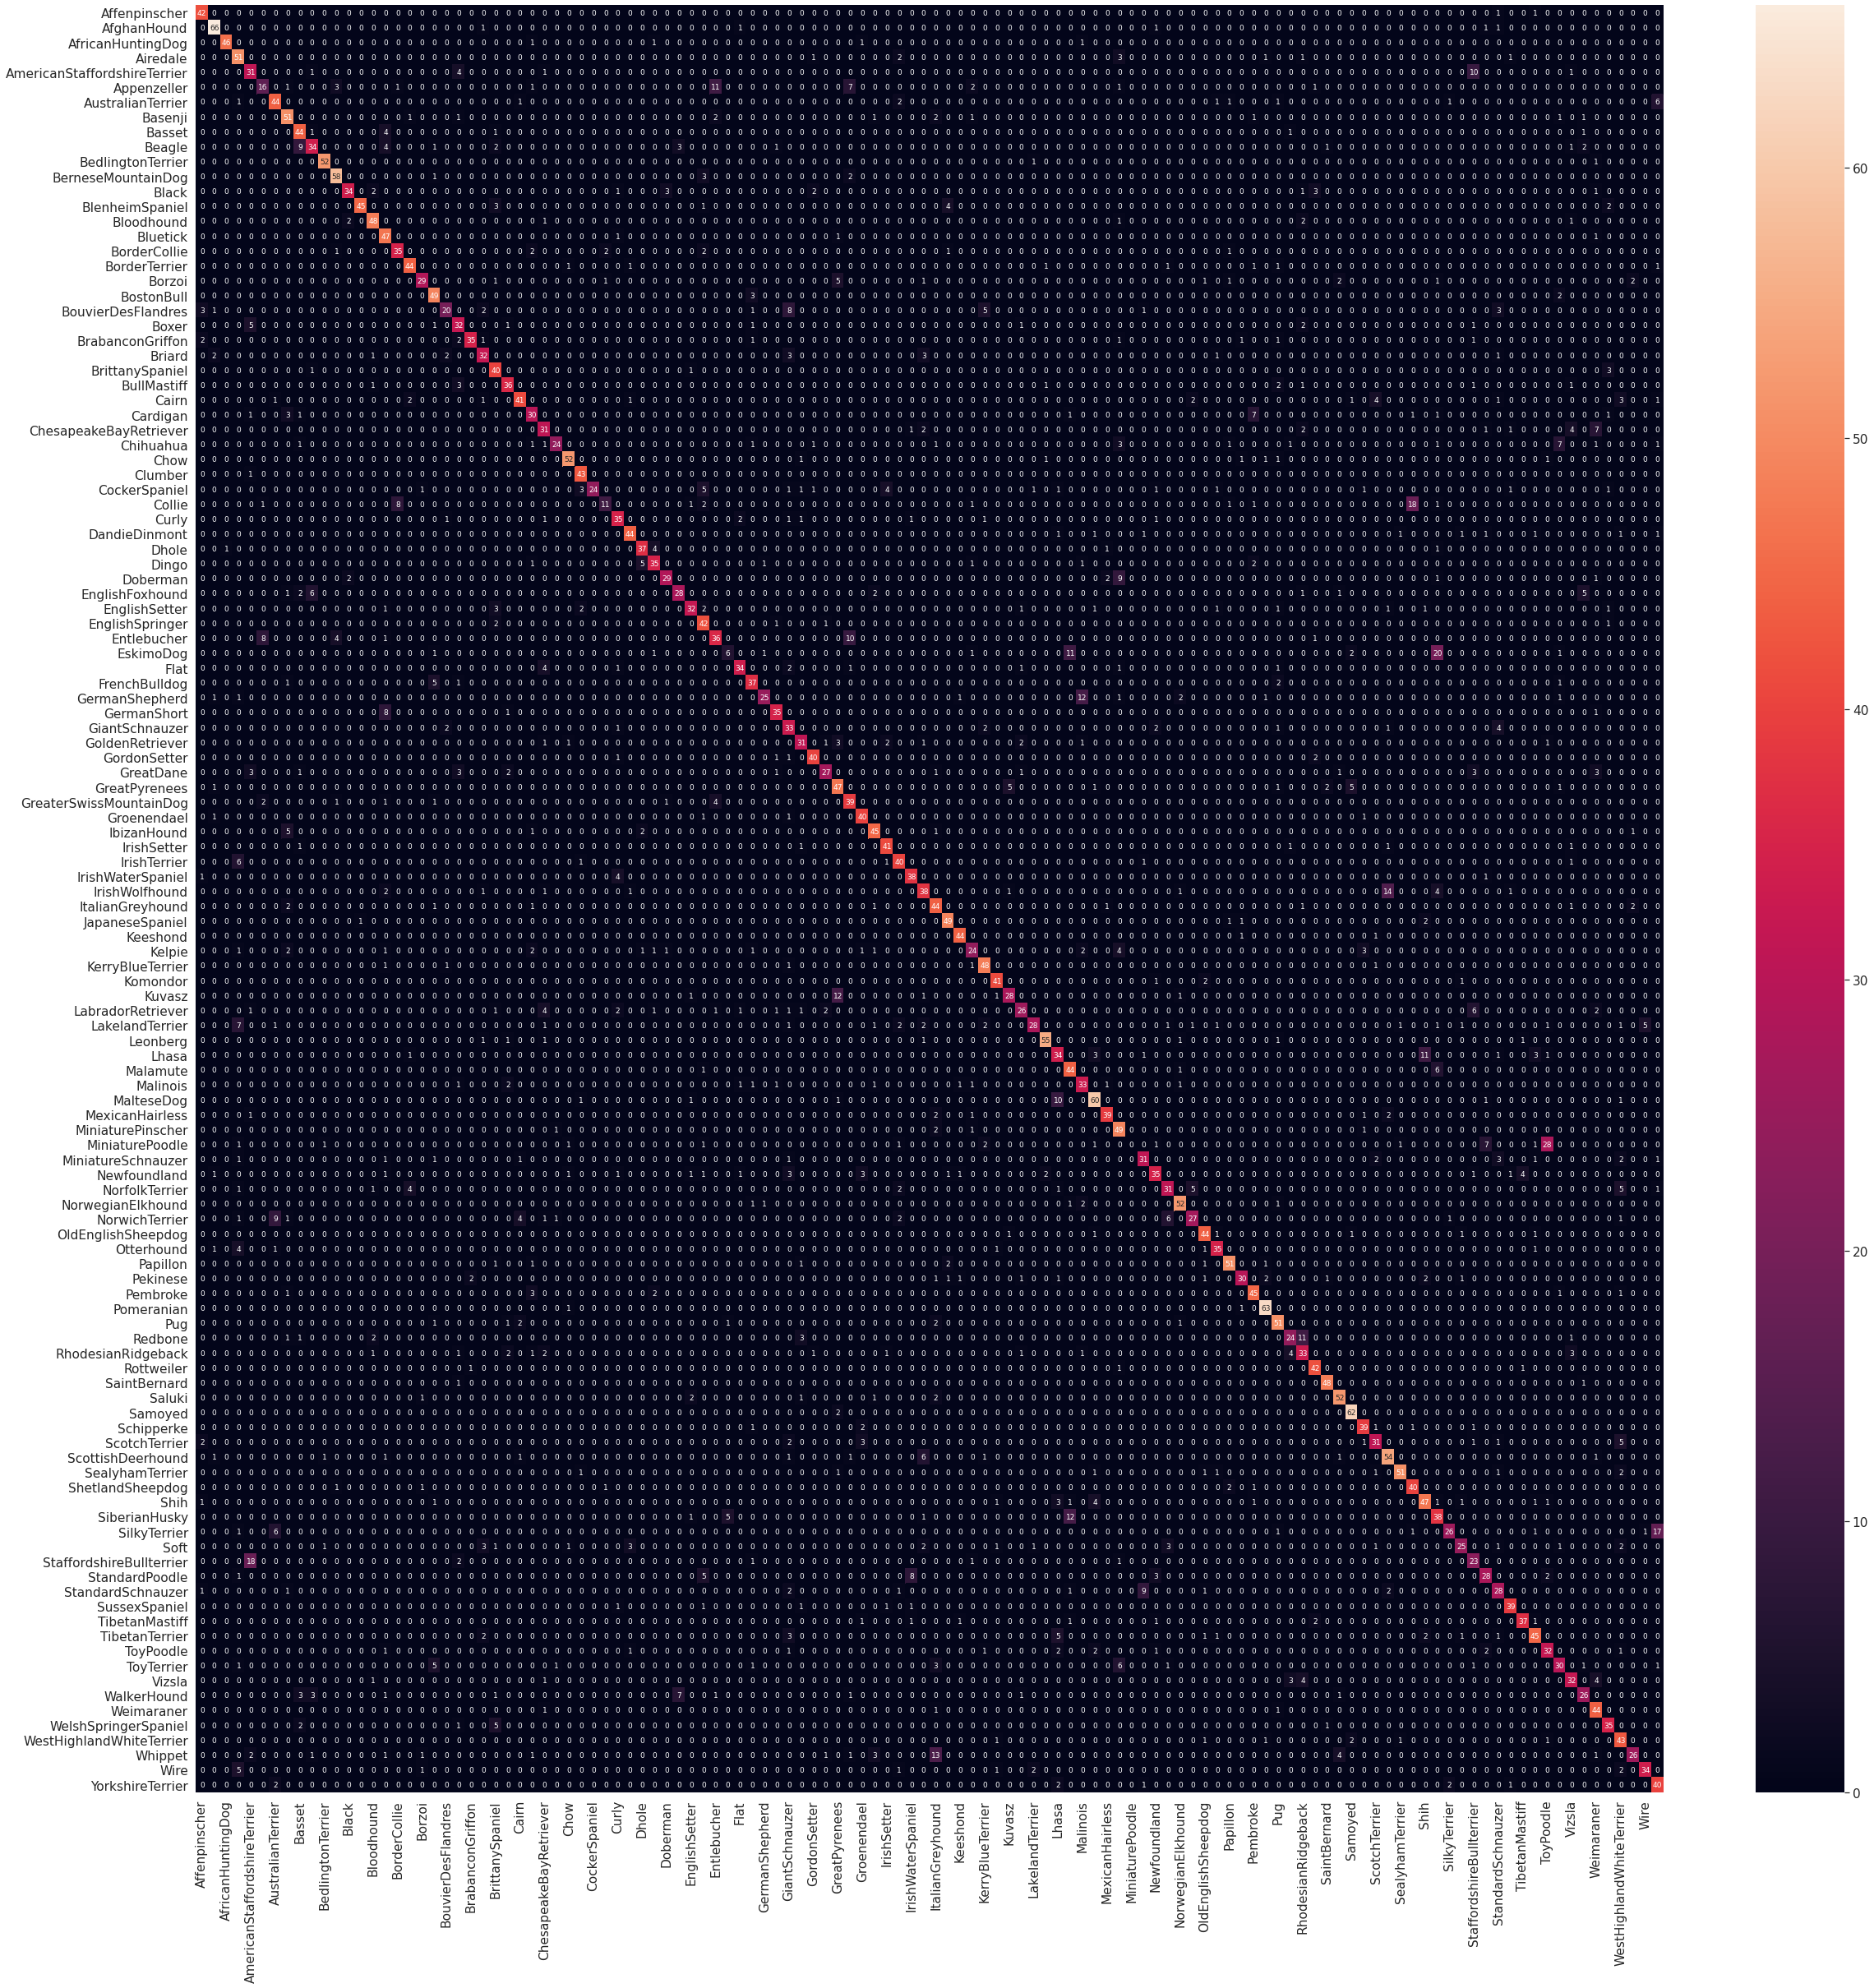

In [36]:
df_cm = pd.DataFrame(confusion_matrix(actualLabels, predictedLabels), main_categories, main_categories)
plt.figure(figsize=(40,40))
sns.set(font_scale=1.4) # for label size
# sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 9}) # font size
plt.show()

In [37]:
print(classification_report(actualLabels, predictedLabels))

                              precision    recall  f1-score   support

               Affenpinscher       0.81      0.95      0.88        44
                 AfghanHound       0.88      0.93      0.90        71
           AfricanHuntingDog       0.98      0.92      0.95        50
                    Airedale       0.61      0.85      0.71        60
AmericanStaffordshireTerrier       0.49      0.65      0.56        48
                 Appenzeller       0.59      0.36      0.45        44
           AustralianTerrier       0.69      0.76      0.72        58
                     Basenji       0.73      0.82      0.77        62
                      Basset       0.68      0.85      0.75        52
                      Beagle       0.72      0.59      0.65        58
           BedlingtonTerrier       0.95      0.96      0.95        54
          BerneseMountainDog       0.85      0.91      0.88        64
                       Black       0.89      0.72      0.80        47
             Blenhe

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
